# Imports & ETL

Small note: The imports and ETL area is quite boring and only needs to be run once. However once you are done it is not going anywhere. If you have not done se yet, it is adviseable to use an extension that allows you to colapse areas in notebooks as well as recieve a Table of Contents on the left. This is not nessesary to use this or any other notebook but the colapsing lets you hide the not so useful cells that you only use sometimes and the Table of Contents lets you jump around the notebook quickly. 

For jupyterhub they can be added by installing nbextensions: https://github.com/ipython-contrib/jupyter_contrib_nbextensions

For jupyterlab they can be added as individual extensions called: @jupyterlab/toc & @aquirdturtle/collapsible_headings

As well in order to enjoy this notebook you will need to install bokeh, you can do this by running:   `conda install -c anaconda bokeh`

Hope you enjoy the Notebook!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# Bokeh imports
from bokeh.io import show, output_notebook, push_notebook
from bokeh.plotting import figure,show,output_notebook,reset_output,output_file

from bokeh.models import CategoricalColorMapper, HoverTool, ColumnDataSource, Panel
from bokeh.models.widgets import CheckboxGroup, Slider, RangeSlider, Tabs

from bokeh.layouts import column, row, WidgetBox
from bokeh.palettes import Category20_16

from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application


from bokeh.core.validation import silence
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
silence(EMPTY_LAYOUT, True)
silence(MISSING_RENDERERS, True)

output_notebook()

Loading BokehJS ...

In [3]:
traffic = pd.concat([pd.read_csv('accidents_2005_to_2007.csv', ),
                    pd.read_csv('accidents_2009_to_2011.csv', ),
                     pd.read_csv('accidents_2012_to_2014.csv', )])

C:\Users\tuvian\AppData\Local\Continuum\miniconda3\envs\ydata\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Drop Junction as it is empty
traffic = traffic.drop('Junction_Detail', axis=1)

In [5]:
traffic.columns

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Control', '2nd_Road_Class', '2nd_Road_Number',
       'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location', 'Year'],
      dtype='object')

## Create Datetime Index

In [6]:
traffic.loc[:, 'dt'] = traffic.Date.str.cat(traffic.Time, sep=' ', na_rep='00:00')

In [7]:
traffic.loc[:, 'date_time'] = pd.to_datetime(traffic.dt, dayfirst=True)

In [8]:
traffic['date_time'] = pd.to_datetime(traffic['date_time'], dayfirst=True)

In [9]:
traffic.set_index('date_time', inplace=True)

## Split weather and winds

In [10]:
import re
traffic['Weather'] = traffic['Weather_Conditions'].apply(lambda x: re.compile("(with|without)").split(str(x))[0])

In [11]:
traffic['High_winds'] = traffic['Weather_Conditions'].str.contains('with high winds')

In [12]:
traffic = traffic.drop(columns=['dt', 'Weather_Conditions'])

In [13]:
traffic['Weather'] = traffic['Weather'].replace(to_replace=[np.nan, 'Fine '], value=['Fine', 'Fine'])

## Rework Light Conditions 

In [14]:
traffic['Light_Conditions'].value_counts()

Daylight: Street light present               1102222
Darkness: Street lights present and lit       296340
Darkeness: No street lighting                  82559
Darkness: Street lighting unknown              16120
Darkness: Street lights present but unlit       6909
Name: Light_Conditions, dtype: int64

In [15]:
traffic['Street_lighting'] = traffic['Light_Conditions'].apply(lambda x: re.compile("(Darkness|Darkeness|Daylight):").split(str(x))[-1])

In [16]:
traffic['Daylight'] = traffic['Light_Conditions'].str.contains("Daylight")

In [17]:
street_lights = [' Street light present', ' Street lights present and lit', ' No street lighting', ' Street lighting unknown', ' Street lights present but unlit']

In [18]:
traffic['Street_lighting'] = traffic['Street_lighting'].replace(to_replace=street_lights, value=['Day', 'Present & On', 'Off', 'Off', 'Off' ])

In [19]:
traffic = traffic.drop(columns=['Light_Conditions'])

## Add Weekday boolean

In [20]:
traffic['Weekday'] = ~((traffic['Day_of_Week'] == 7) | (traffic['Day_of_Week'] == 1))

In [21]:
traffic['Weekday'].value_counts()

True     1137765
False     366385
Name: Weekday, dtype: int64

## Remove third category from Urban or Rural 

In [22]:
traffic.loc[traffic['Urban_or_Rural_Area'] == 1, 'Urban_or_Rural_Area'] = 'Urban'

In [23]:
traffic.loc[(traffic['Urban_or_Rural_Area'] == 2) | (traffic['Urban_or_Rural_Area'] == 3), 'Urban_or_Rural_Area'] = 'Rural'

## Stringify Accident Severity for readability

In [24]:
traffic['Accident_Severity'] = traffic['Accident_Severity'].replace(to_replace=[1,2,3], value=['Fatal', 'Serious', 'Slight'])

## Function to convert long and latitudes to x and y coord for Bokeh

In [25]:
# Function used to get x and y cocrds for Bokeh:
def coordinates_to_x_y(df, lon="Longitude", lat="Latitude"):
    k = 6378137
    df["x"] = df[lon] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k

    return df

In [26]:
traffic= coordinates_to_x_y(traffic)

## Removing some nan's, adding some strings for Bokeh Purposes

In [27]:
traffic['Weather'] = traffic['Weather'].replace(to_replace=[np.nan], value=['Fine'])

In [28]:
traffic['Speed_String'] = traffic['Speed_limit'].astype(str)

## Few small additional cleaning of the data

In [29]:
traffic['Speed_String'] = traffic['Speed_limit'].astype(str)
Severity_List = list(traffic.Accident_Severity.unique())
Severity_List.sort()

In [30]:
# this was two notebooks that were combined so we 'add' a variable name for our dataframe so as not to chang it all by hand
df = traffic

# Introduction

Now that we are done proccessing our data lets get down to the interesting part.

We have decided to do a deep dive into fatal accidents. We will try to understand them as best we can and in particular try to answer the following questions:
1. What are the leading causes of fatal accidents
2. When do fatal accidents most occur.
3. How can we prevent fatal accidents?

The way we can get a look at fatalities is through Accident Severity. There are 3 options in accident severity:
1. Fatal
2. Serious
3. Slight

Within the confines of this dataset there is no way to know how many fatalities there were in a car accident only if the accident had fatalities so we cannot adress the severity within fatal (as in we cannot say how many fatalities there were, we have the column casualties, but those are not nessesarily fatalities) so we will treat all fatal accidents the same and treat them all with equal weight even though in reality some have more fatalities than others.
We will start by taking a look into what we are using as our "target". We want to get a good understanding of Accident Severity by itself before we understand it compared to or in contrast to other features. 

## Accident Severity

In [31]:
df['Accident_Severity'].value_counts(dropna=False)

Slight     1280205
Serious     204504
Fatal        19441
Name: Accident_Severity, dtype: int64

In [32]:
df['Accident_Severity'].value_counts(dropna=False) / df['Accident_Severity'].size

Slight     0.851115
Serious    0.135960
Fatal      0.012925
Name: Accident_Severity, dtype: float64

First thing that we can see is that only 1.3% of the accidents that happen are fatal. Thats a great start! But it is still about over 2,000 fatal accidents a year. Thats about 5-6 fatal accidents a day. Lets see if there are more and less fatal times of the year.

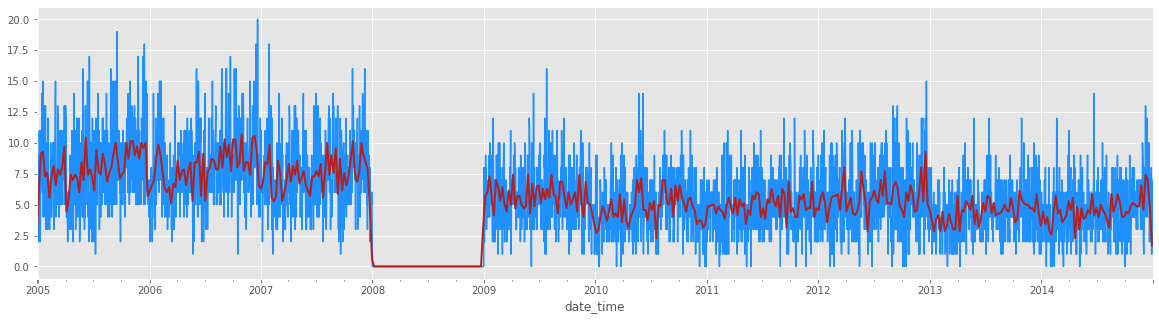

In [33]:
plt.figure(figsize=(20,5))
df[df['Accident_Severity'] == 'Fatal'].resample('D').size().T.plot(ax=plt.gca(), color='dodgerblue')
(df[df['Accident_Severity'] == 'Fatal'].resample('W').size()/7).T.plot(ax=plt.gca(), color='firebrick', linewidth=2)

So the daily view is a little too precise and not much of a pattern shines throught. Lets take a look at a monthly view. Also note, the data set provide is missing 2008.

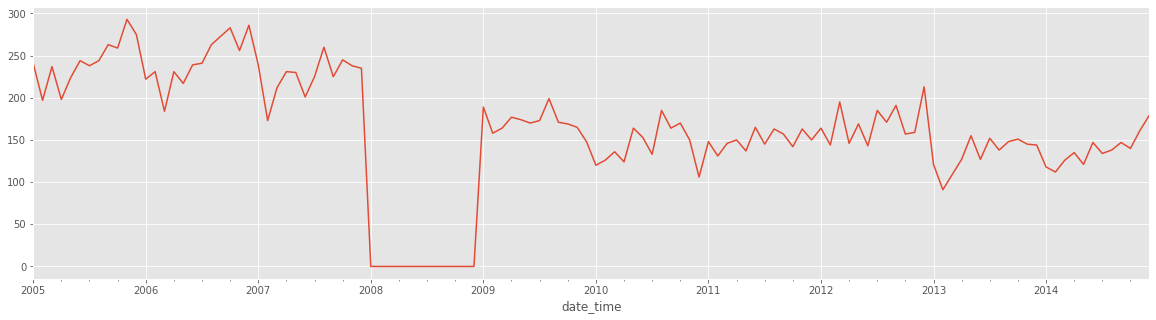

In [34]:
plt.figure(figsize=(20,5))
df[df['Accident_Severity'] == 'Fatal'].resample('M').size().T.plot(ax=plt.gca())

Ok so thats a bit better but not much. We can see that there is a very slow downward trend which is promising.

In between 2005-2008 it seems that there may be a seasonal effect but with an average of about 250 accidents a month. Then we are missing a year of data and when we start 2009 we have a average of about 150 fatal accidents a month. Between 2009-2013 we dont see any seasonal effect but rather a slow upward trend (the minor differences between months can be explained by the different amount of days per month). Then as we start 2013 there is a steep drop in fatal accidents with an average of about 125 accidents per month for 2013-2014.

 Lets now explore where these accidents occured geographically:

In [35]:
# This chooses the feature for the legend
col = 'Accident_Severity'
feat_list = list(df[col].unique())
feat_list.sort()

Below is the Bokeh code used, for more details about it, let us know and we can send you the test notebook with
more explanations. The map is very interactive with a year range slider and checkbox for Severity. Additionally, there are a few built in tabs along the right side of the map which allow you to zoom, pan, reset the map and highlight a specific area of the map (which will zoom in on it).

Note: Due to the large number of data points, it may slow down or crash when you select all 3 Severity Types in one go. You can try, but best to play with them seperately.

In [36]:
def modify_doc(doc):
    from bokeh.tile_providers import CARTODBPOSITRON

    
    def make_dataset(feat_list,Accident_Severity_list,year_select_list):
        #setup df to store ouput in
        df_use = pd.DataFrame(columns = df.columns ) 

       #Filter to years we want from slider
        df_years = df[(df.Year >= year_select_list[0])  & (df.Year <= year_select_list[1]) & (df.Accident_Severity.isin(Accident_Severity_list))]
        
        #Main reason for looping is to add sperate colours for legend per dataset combination of  feature in question
        for i, feat in enumerate(feat_list):
            subset = df_years[(df_years[col] == feat)].copy()

            # Color each Type of weather differently, put in times 2 to try make it really different
            subset['color'] = Category20_16[(i)*2]
            df_use = df_use.append(subset)

        return ColumnDataSource(df_use)

    # Adding a touch of styling
    def style(p):
        # Title 
        p.title.align = 'center'
        p.title.text_font_size = '20pt'
        p.title.text_font = 'serif'

        # Axis titles
        p.xaxis.axis_label_text_font_size = '14pt'
        p.xaxis.axis_label_text_font_style = 'bold'
        p.yaxis.axis_label_text_font_size = '14pt'
        p.yaxis.axis_label_text_font_style = 'bold'

        # Tick labels
        p.xaxis.major_label_text_font_size = '12pt'
        p.yaxis.major_label_text_font_size = '12pt'

        return p
    
    def make_plot(src):
        
        #This makes a boundary box of the coordanites of the chunk of the world map we want.
        BBox = ((src.data['x'].min(),src.data['x'].max(),src.data['y'].min(), src.data['y'].max()))
        
         
        p = figure(x_range = (BBox[0],BBox[1]),y_range = (BBox[2],BBox[3]),
                   x_axis_type="mercator",y_axis_type="mercator",title = 'Accident Locations in the UK',x_axis_label = 'Latitude', 
                   y_axis_label = 'Longitude')
        
        p.add_tile(CARTODBPOSITRON)
        
        # To add an additional legend, may have to use this: https://github.com/bokeh/bokeh/issues/3880
        # Below actually plots ciclres at the site of every accident
        p.circle(source = src, x='x',
        y='y',color = 'color',
                 legend_field=col,
                fill_alpha = 0.7,hover_fill_alpha = 1.0, 
                 line_color = 'black')

        # Styling
        p = style(p)

        return p
    
        # Update function takes three default parameters
    def update(attr, old, new):
        # Get the list for this features to add to map
        feature_to_plot = [feature_selection.labels[i] for i in 
                            feature_selection.active]
        severity_to_plot = [severit_selection.labels[i] for i in 
                            severit_selection.active]
        year_to_plot = [year_select.value[0],year_select.value[1]]

        # Make a new dataset based on the selected carriers and the 
        # make_dataset function defined earlier
        new_src = make_dataset(feature_to_plot,severity_to_plot,year_to_plot) #Will need to add any any additional filters

        # Update the source used in the  glpyhs
        src.data.update(new_src.data)

    #Note the wierd syntax list(range(len(feat_list))), is so that we have a number that correlates to each item in list
    feature_selection = CheckboxGroup(labels=feat_list, active = [0])
    feature_selection.on_change('active', update)
    
   # severit_selection = CheckboxGroup(labels=Severity_List, active = [0,1,2])
    severit_selection = CheckboxGroup(labels=Severity_List, active = [0,1,2])

    severit_selection.on_change('active', update)
    
    year_select = RangeSlider(start = 2005, end =2011, value = (2005, 2006),
                               step = 1, title = 'Year')
    year_select.on_change('value', update)
    
    controls = WidgetBox(feature_selection,year_select)


    
    initial_feature = [feature_selection.labels[i] for i in feature_selection.active]
    initial_severity = ['Fatal']

    # nb this may throw things off the year select
    src = make_dataset(initial_feature,initial_severity,[year_select.value[0],year_select.value[1]])

    p = make_plot(src)
    
    layout = row(controls, p)
    doc.add_root(layout)
    
# Set up an application
handler = FunctionHandler(modify_doc)
app = Application(handler)


In [37]:
# Run this to see interactive Map
# I have disables Bokeh for uploading this to github, but if you download it locally just uncomment the line below and the interactive dashboard will run
# show(app)

As can be seen above, accidents occur all over the UK, with a large number of them occuring within cities.

# Plots by percentage of Accident Severity

So without further ado lets dive into the five categories that we found had the highest most interesting in comparison to fatalities in car accidents (In no particular order):

1. Street_lighting
2. Weekday
3. Urban_or_Rural_Area
4. Weather
5. Speed_limit

# Weather

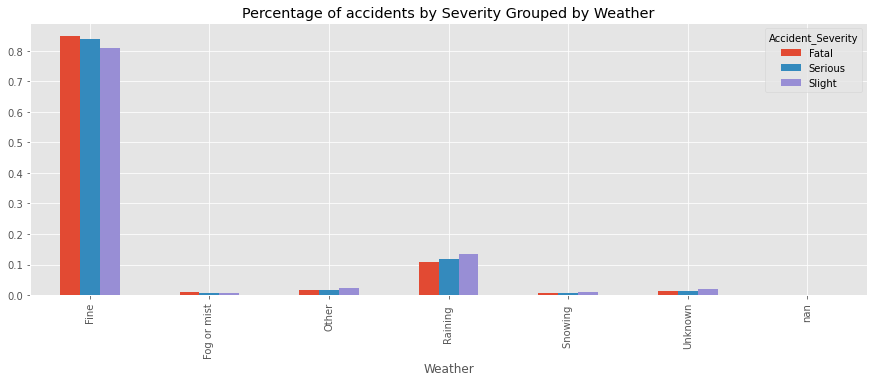

In [38]:
col = 'Weather'
col_groups = df.groupby(['Accident_Severity',  col,]).size() / df.groupby(['Accident_Severity']).size()
col_groups.unstack().T.plot(kind='bar', title=f"Percentage of accidents by Severity Grouped by {col}", figsize=(15,5))

Lets take a quick look at this graph and understand what we are looking at. For each Accident Severity, fatal, serious, and slight we have the percentage of accidents per weather type. So for example we can see that if you are in a fatal accident there is about an 85% chance that the weather was Fine. This is a good way to compare the different categories to each other. For example, here we can see that against intuition there is a lower rate of fatalities when the weather is bad and a higher rate when the weather is fine. this is most likely because people are more careful when the weather is bad which leads to fewer accidents.

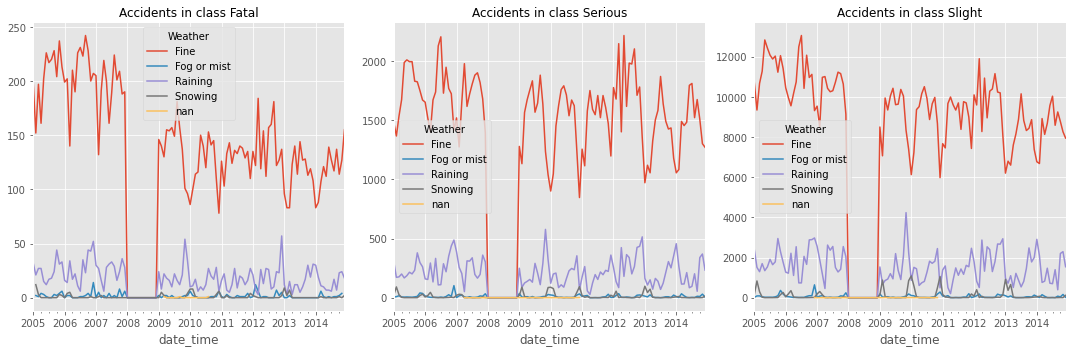

In [39]:
tsdf = df[~(df[col].isin(['Fine ', 'Unknown', 'Other']))].groupby(['Accident_Severity', col]).resample('M').size()

plt.figure(figsize=(15, 5))
for idx, severity in enumerate(['Fatal', 'Serious', 'Slight']):
    plt.subplot(1, 3, idx + 1)
    tsdf.loc[severity].unstack().T.plot(ax=plt.gca())
    plt.title("Accidents in class %s" % severity, fontsize=12)
plt.tight_layout()
plt.show()

When looking at the severe weather categories per Severity type not much jumps out at us. The graphs all look about the same, just notice that the counts are of different sizes which can be confusing. But if we didnt do it this way we would not be able to make out the granularity of the fatal class.

Lets take a look at this geographically. There is now an additional checkbox which should allow you to change the weather conditions on the map. The map emphasizes the points made above.

In [40]:
feat_list = list(df[col].unique())
feat_list = list(map(str, feat_list))
feat_list.sort()

In [41]:
def modify_doc(doc):
    from bokeh.tile_providers import CARTODBPOSITRON

    
    def make_dataset(feat_list,Accident_Severity_list,year_select_list):
        #setup df to store ouput in
        df_use = pd.DataFrame(columns = df.columns ) 

       #Filter to years we want from slider
        df_years = df[(df.Year >= year_select_list[0])  & (df.Year <= year_select_list[1]) & (df.Accident_Severity.isin(Accident_Severity_list))]
        
        #Main reason for looping is to add sperate colours for legend per dataset combination of  feature in question
        for i, feat in enumerate(feat_list):
            subset = df_years[(df_years[col] == feat)].copy()

            # Color each Type of weather differently, put in times 2 to try make it really different
            subset['color'] = Category20_16[(i)*2]
            df_use = df_use.append(subset)

        return ColumnDataSource(df_use)

    # Adding a touch of styling
    def style(p):
        # Title 
        p.title.align = 'center'
        p.title.text_font_size = '20pt'
        p.title.text_font = 'serif'

        # Axis titles
        p.xaxis.axis_label_text_font_size = '14pt'
        p.xaxis.axis_label_text_font_style = 'bold'
        p.yaxis.axis_label_text_font_size = '14pt'
        p.yaxis.axis_label_text_font_style = 'bold'

        # Tick labels
        p.xaxis.major_label_text_font_size = '12pt'
        p.yaxis.major_label_text_font_size = '12pt'

        return p
    
    def make_plot(src):
        
        #This makes a boundary box of the coordanites of the chunk of the world map we want.
        BBox = ((src.data['x'].min(),src.data['x'].max(),src.data['y'].min(), src.data['y'].max()))
        
         
        p = figure(x_range = (BBox[0],BBox[1]),y_range = (BBox[2],BBox[3]),
                   x_axis_type="mercator",y_axis_type="mercator",title = 'Accident Locations in the UK',x_axis_label = 'Latitude', 
                   y_axis_label = 'Longitude')
        
        p.add_tile(CARTODBPOSITRON)
        
        # To add an additional legend, may have to use this: https://github.com/bokeh/bokeh/issues/3880
        # Below actually plots ciclres at the site of every accident
        p.circle(source = src, x='x',
        y='y',color = 'color',
                 legend_field=col,
                fill_alpha = 0.7,hover_fill_alpha = 1.0, 
                 line_color = 'black')

        # Styling
        p = style(p)

        return p
    
        # Update function takes three default parameters
    def update(attr, old, new):
       
        # Get the list for this features to add to map
        feature_to_plot = [feature_selection.labels[i] for i in 
                            feature_selection.active]
        severity_to_plot = [severit_selection.labels[i] for i in 
                            severit_selection.active]
        year_to_plot = [year_select.value[0],year_select.value[1]]

        # Make a new dataset based on the selected carriers and the 
        # make_dataset function defined earlier
        new_src = make_dataset(feature_to_plot,severity_to_plot,year_to_plot) #Will need to add any any additional filters


        # Update the source used in the  glpyhs
        src.data.update(new_src.data)
    
    #Note the wierd syntax list(range(len(feat_list))), is so that we have a number that correlates to each item in list
    feature_selection = CheckboxGroup(labels=feat_list, active = list(range(len(feat_list))))
    feature_selection.on_change('active', update)
    
    severit_selection = CheckboxGroup(labels=Severity_List, active = [0])

    severit_selection.on_change('active', update)
    
    year_select = RangeSlider(start = 2005, end =2011, value = (2005, 2006),
                               step = 1, title = 'Year')
    year_select.on_change('value', update)
    
    controls = WidgetBox(feature_selection,severit_selection,year_select)

    
    initial_feature = [feature_selection.labels[i] for i in feature_selection.active]
    initial_severity = ['Fatal']

    # this may throw things off the year select
    src = make_dataset(initial_feature,initial_severity,[year_select.value[0],year_select.value[1]])

    
    p = make_plot(src)
    
    layout = row(controls, p)
    doc.add_root(layout)
    
# Set up an application
handler = FunctionHandler(modify_doc)
app = Application(handler)


In [42]:
# I have disables Bokeh for uploading this to github, but if you download it locally just uncomment the line below and the interactive dashboard will run
# show(app)

# Speed_limit

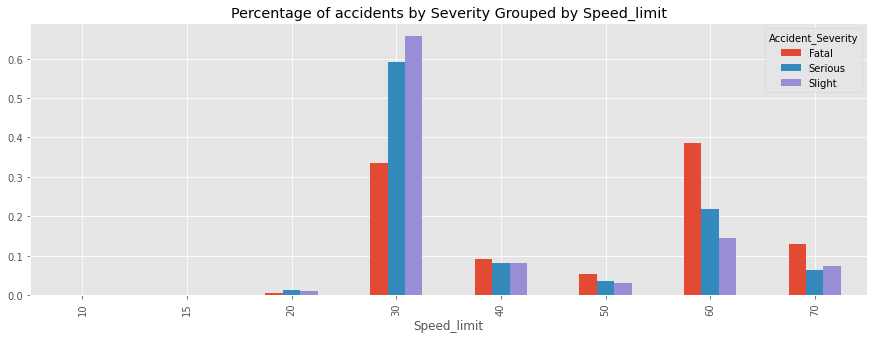

In [43]:
col = 'Speed_limit'
col_groups = df.groupby(['Accident_Severity',  col,]).size() / df.groupby(['Accident_Severity']).size()
col_groups.unstack().T.plot(kind='bar', title=f"Percentage of accidents by Severity Grouped by {col}", figsize=(15,5))

This graph is closer to what we would expect of it to be. There arent many areas with a speed limit of 10-20 and if where there are there arent many accidents there because of the slowness of traffic. However there are many areas with a speed limit of 30. But because this is still slow there is a much lower percentage of fatal accidents and a much higher percentage of severe and slight accidents.

It seems there arent that many areas with 40-50 as the speed limit as well but we can see that even there fatal is getting a higher probability*. When we get to 60-70 is where we can see how much speed limit (and thus most likely aproximate speed of at least one of the cars at time of accident) effects fatality rates. This is very intuitive, the faster the car is going at the time of impact the more likly it is to be a fatal accident.


*NOTE: This does not mean that it is more likely than a serious or slight accident. It means that 40% of fatal accidents happen at speed 60 where only 15% of slight accidents happen here. There are still many more slight accidents and thus more accidents by count at this speed.

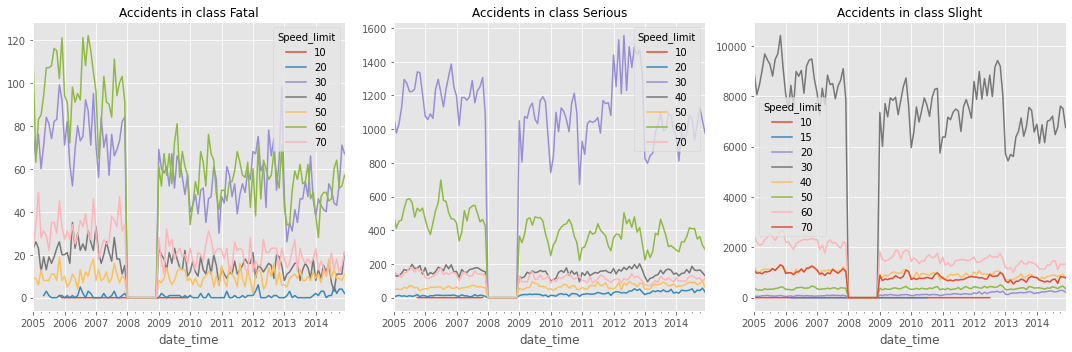

In [44]:
tsdf = df.groupby(['Accident_Severity', col]).resample('M').size()

plt.figure(figsize=(15, 5))
for idx, severity in enumerate(['Fatal', 'Serious', 'Slight']):
    plt.subplot(1, 3, idx + 1)
    tsdf.loc[severity].unstack().T.plot(ax=plt.gca())
    plt.title("Accidents in class %s" % severity, fontsize=12)
plt.tight_layout()
plt.show()

Once again not much in the way of time series. A small downward slope can be seen, but that is a general pattern we saw in fatalities so not unique to this plot.

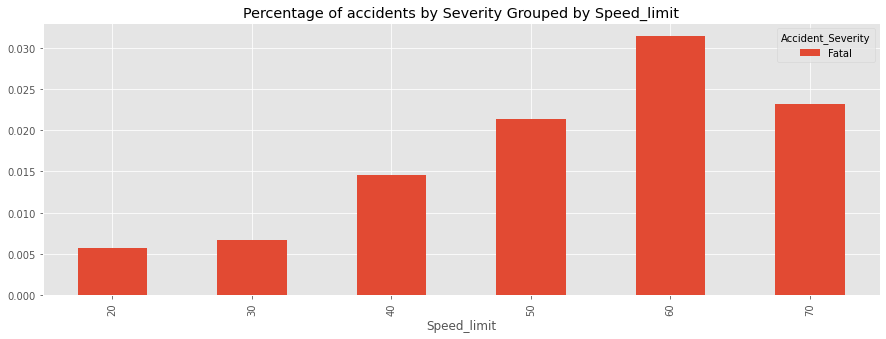

In [45]:
col_groups = df[(df['Accident_Severity'] =='Fatal') & (df['Speed_limit'] > 10)].groupby(['Accident_Severity',  col,]).size() / df.groupby([col]).size()
col_groups.unstack().T.plot(kind='bar', title=f"Percentage of accidents by Severity Grouped by {col}", figsize=(15,5))

This graph is also very interesting. We can see the percentage of fatal crashes at each speed. 

I think it speaks for itself.


#### Food for thought: Where did these accidents occur? Highway? Rural roads?

Using a geographic plot of the speed limits, we may be able to infer this. Play around with the checkbox for different speed limits (selecting 1 or 2 at a time) and see if making it higher marks out what looks like Highways etc.... For example, set the speed limit to 70 and choose the severity to be Fatal & Serious, can you see the highways? Now add 60 to the speed limit and Slight to the severity to really emphasize them.

In [46]:
col = 'Speed_String'
feat_list = list(df[col].unique())
feat_list = list(map(str, feat_list))
feat_list.sort()

In [47]:
# Set up an application
handler = FunctionHandler(modify_doc)
app = Application(handler)


In [48]:
show(app)

# Street_lighting

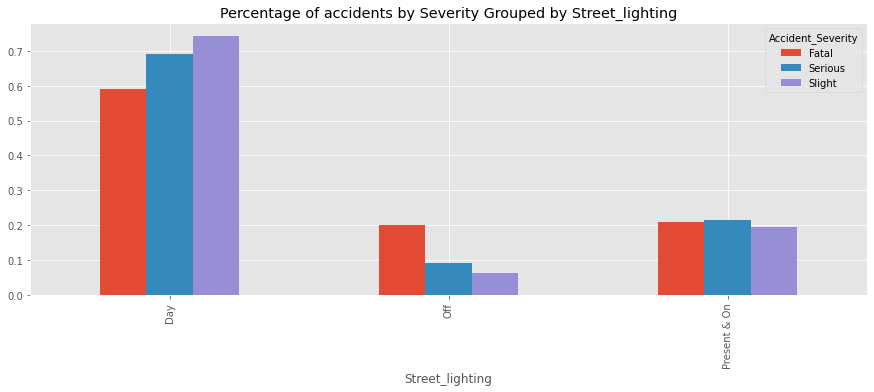

In [49]:
col = 'Street_lighting'
col_groups = df.groupby(['Accident_Severity',  col,]).size() / df.groupby(['Accident_Severity']).size()
col_groups.unstack().T.plot(kind='bar', title=f"Percentage of accidents by Severity Grouped by {col}", figsize=(15,5))

Here to we are presented with something rathe intuitive. A smaller percentage of fatal accidents happen during the day compared to serious and slight. But once it becomes night, with light they have equal percentages and without light fatalities have the highest percentage.

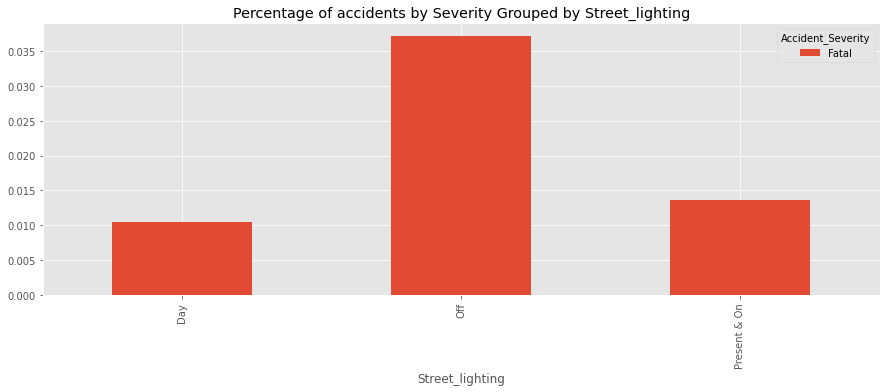

In [50]:
col_groups = df[(df['Accident_Severity'] =='Fatal') & (df['Speed_limit'] > 10)].groupby(['Accident_Severity',  col,]).size() / df.groupby([col]).size()
col_groups.unstack().T.plot(kind='bar', title=f"Percentage of accidents by Severity Grouped by {col}", figsize=(15,5))

This drives home the above graph as we can see that At night with lights on the percentage of fatal accidents is ~40% higher but without lights it jumps to be 250% larger.

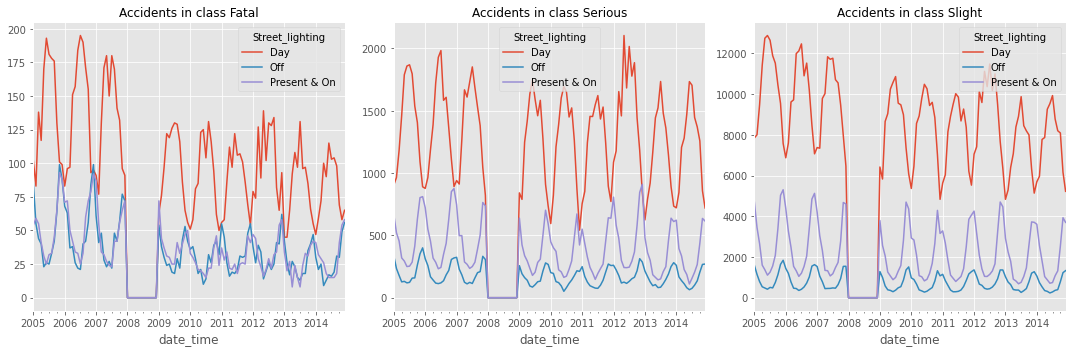

In [51]:
tsdf = df.groupby(['Accident_Severity', col]).resample('M').size()

plt.figure(figsize=(15, 5))
for idx, severity in enumerate(['Fatal', 'Serious', 'Slight']):
    plt.subplot(1, 3, idx + 1)
    tsdf.loc[severity].T.plot(ax=plt.gca())
    plt.title("Accidents in class %s" % severity, fontsize=12)
plt.tight_layout()
plt.show()

We can see a very clear sesonality here. In the summer more fatalities happen during the day and during the summer more fatalities happen during the day. We need to be careful because in the winter the day is shorter so of course there are fewer accidents during the day but this seems to be more than that. 

We can plot these geographically. Notice that in Northern England, where there are a lot of national parks, there is not as much steet lighting as in the South (where most accidents occur in big cities and highways).

In [52]:
feat_list = list(df[col].unique())
feat_list = list(map(str, feat_list))
feat_list.sort()

In [53]:
handler = FunctionHandler(modify_doc)
app = Application(handler)


In [54]:
show(app)

#### Food for thought: When do these accidents take place? Late at night or in the evening/morning?

# Weekday

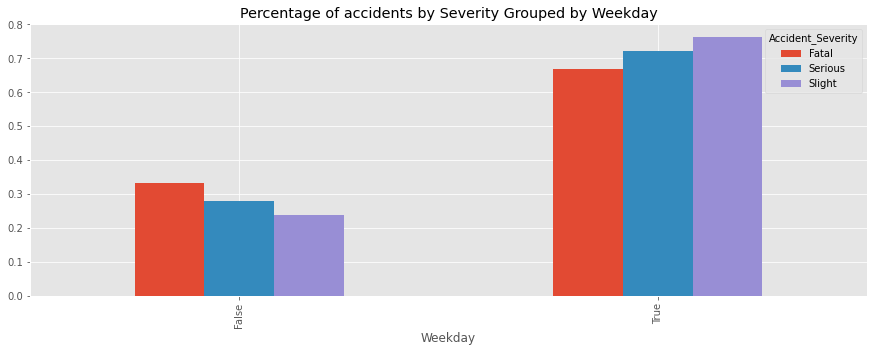

In [55]:
col = 'Weekday'
col_groups = df.groupby(['Accident_Severity',  col,]).size() / df.groupby(['Accident_Severity']).size()
col_groups.unstack().T.plot(kind='bar', title=f"Percentage of accidents by Severity Grouped by {col}", figsize=(15,5))

It seems to me that the above can be explained by the fact that people are more likely to go on "joyrides" and are genreally more reckless on the weekend than during the week on their boring daily commute to work.

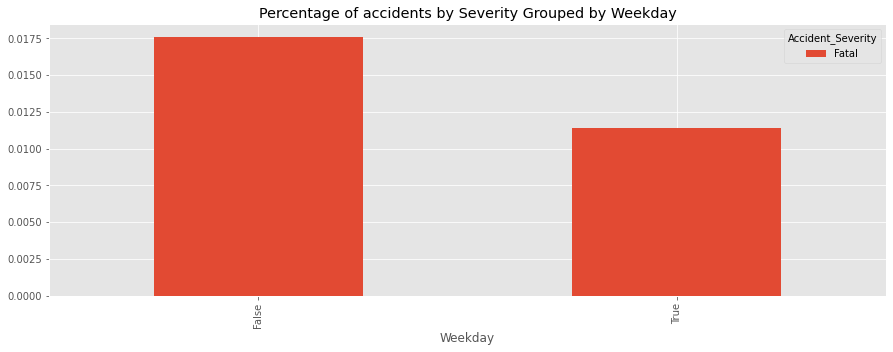

In [56]:
col_groups = df[(df['Accident_Severity'] =='Fatal') & (df['Speed_limit'] > 10)].groupby(['Accident_Severity',  col,]).size() / df.groupby([col]).size()
col_groups.unstack().T.plot(kind='bar', title=f"Percentage of accidents by Severity Grouped by {col}", figsize=(15,5))

This translates into a the weekend having a higher percentage of fatal accidents.

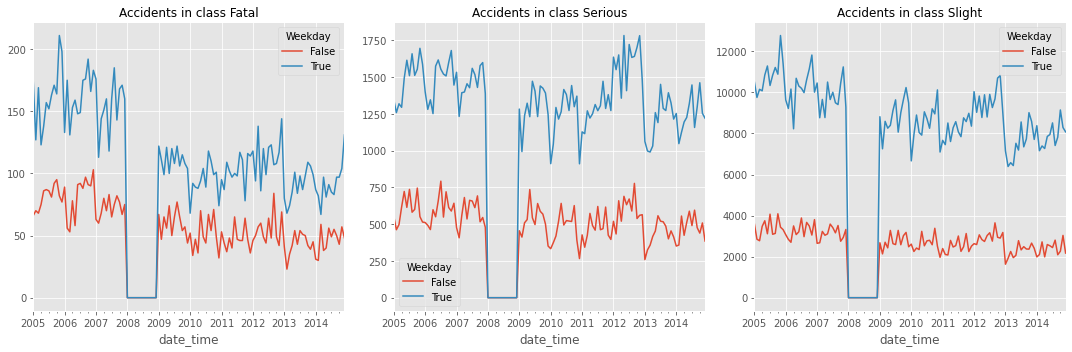

In [57]:
tsdf = df.groupby(['Accident_Severity', col]).resample('M').size()

plt.figure(figsize=(15, 5))
for idx, severity in enumerate(['Fatal', 'Serious', 'Slight']):
    plt.subplot(1, 3, idx + 1)
    tsdf.loc[severity].T.plot(ax=plt.gca())
    plt.title("Accidents in class %s" % severity, fontsize=12)
plt.tight_layout()
plt.show()

What would be interesting to look into here is why there is a sudden downward spike between Dec. 2012 to Jan 2013. We see this spike in the general Accident_Severity plot but here it seems more pronounced. Yes there are other dips but this one seems deeper and longer lasting.

#### Food for thought: What could cause such a sudden steep decline in accidents?

Yes the holidays could cause part of the decline for anuary but then why is it still very low in February?

# Urban_or_Rural_Area

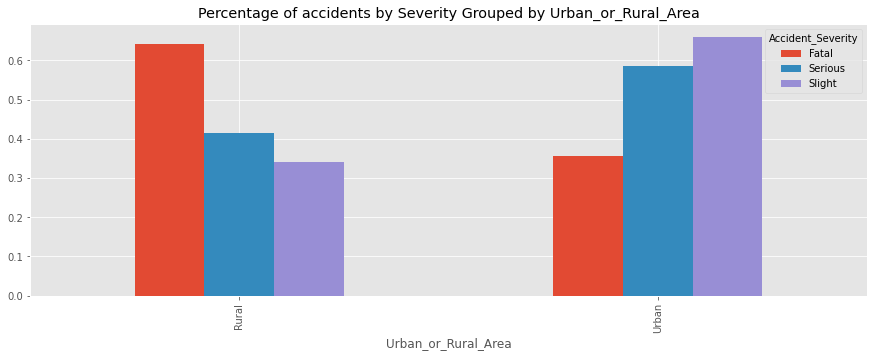

In [58]:
col = 'Urban_or_Rural_Area'
col_groups = df.groupby(['Accident_Severity',  col,]).size() / df.groupby(['Accident_Severity']).size()
col_groups.unstack().T.plot(kind='bar', title=f"Percentage of accidents by Severity Grouped by {col}", figsize=(15,5))

It seems to me that the above can be explained by the fact that people are more likely to go on "joyrides" and are genreally more reckless on the weekend than during the week on their boring daily commute to work.

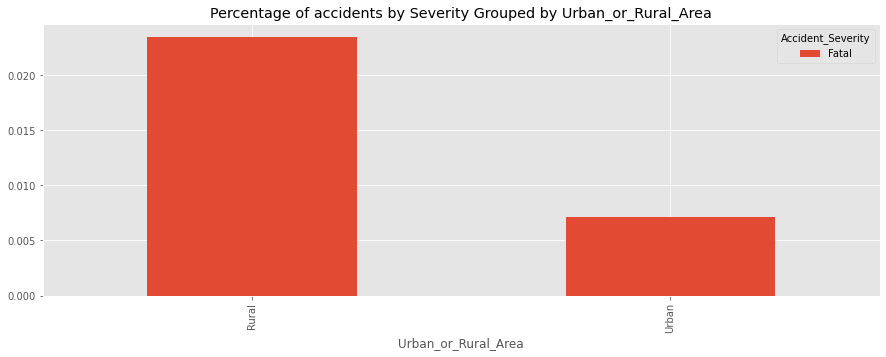

In [59]:
col_groups = df[(df['Accident_Severity'] =='Fatal') & (df['Speed_limit'] > 10)].groupby(['Accident_Severity',  col,]).size() / df.groupby([col]).size()
col_groups.unstack().T.plot(kind='bar', title=f"Percentage of accidents by Severity Grouped by {col}", figsize=(15,5))

This translates into a the weekend having a higher percentage of fatal accidents.

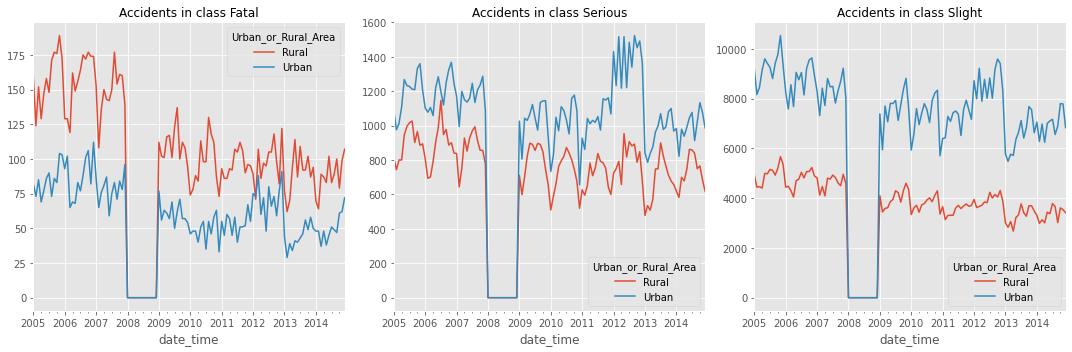

In [60]:
tsdf = df.groupby(['Accident_Severity', col]).resample('M').size()

plt.figure(figsize=(15, 5))
for idx, severity in enumerate(['Fatal', 'Serious', 'Slight']):
    plt.subplot(1, 3, idx + 1)
    tsdf.loc[severity].T.plot(ax=plt.gca())
    plt.title("Accidents in class %s" % severity, fontsize=12)
plt.tight_layout()
plt.show()

What would be interesting to look into here is why there is a sudden downward spike between Dec. 2012 to Jan 2013. We see this spike in the general Accident_Severity plot but here it seems more pronounced. Yes there are other dips but this one seems deeper and longer lasting.

#### Food for thought: What could cause such a sudden steep decline in accidents?

Yes the holidays could cause part of the decline for January but then why is it still very low in February?

In [61]:
df['Urban_or_Rural_Area'].value_counts()

Urban    972007
Rural    532143
Name: Urban_or_Rural_Area, dtype: int64

In [62]:
df[['Speed_limit', 'Number_of_Casualties', 'Daylight', 'Weekday', 'Accident_Severity','Urban_or_Rural_Area']].groupby(['Accident_Severity', 'Urban_or_Rural_Area']).mean()

Speed_limit  Number_of_Casualties  \
Accident_Severity Urban_or_Rural_Area                                      
Fatal             Rural                  56.923508              2.067451   
                  Urban                  33.908973              1.561861   
Serious           Rural                  52.883165              1.681084   
                  Urban                  31.659171              1.290942   
Slight            Rural                  51.801883              1.424325   
                  Urban                  31.847978              1.276259   

                                       Daylight   Weekday  
Accident_Severity Urban_or_Rural_Area                      
Fatal             Rural                0.607057  0.652904  
                  Urban                0.558836  0.695521  
Serious           Rural                0.707277  0.686198  
                  Urban                0.678639  0.747534  
Slight            Rural                0.745612  0.747521  
                  Urban                0.739702  0.771329

#### Food for thought: Above is a table indexed by Accident Severity and Urban or Rural for the mean of a set of categories. What can you make out of it? Can you think of any other interesting categories to add?

# Summary

So that was a lot. At the same time we havent even started to make a dent. We only chose 5 categories and even those only went so deep. There are a ton of things that could be looked into for this dataset. But at the same time we want to come away with practical advice. So here we go:

We saw two main issues that came up in the categories.

1. Condition at time of crash
        a. Street lighting at night is extremely important. It can help save lives.*
        b. Speed limits & Urbanity clearly show that the most dangerous areas are not the highways but rather countyr roads which have a high speed limit but are not highways. Many of these are found in the rural areas of the country and because these roads are not highways they are not as straight, less upkept and have generally poorer conditions for driving. All of the above coupled with the fact that you can go almost as fast as a highway is a deadly combination.  
    
*Is street lighting important or are accidents more likely to occur in areas without street lighting for other reasons? Lack of lights could indicate general poor road conditions? This still relates to point b but is worth considering.

2. Changes in human behavior 
        a. A higher percentage of fatal accidents happen on the weekend because people are more reckless.
        b. A lower percentage of fatal accidents happen when there is bad weather because people are more careful.
        c. (Both of the above are suumptions based on our indeings that need to be checked but which we strongly believed would be confirmed)
    
    
How can we fix these things?

1. Fixing issues of this type are costly and time consuming. It is hard to keep up with all the problems and to make all the roads safe. Further research should be put into areas or roads that have a high fatality rate to try and understand what makes them more fatal than others. This is reactionary, but as we get a better understanding of what causes the issues we can fix them before they become a problem.

2. Problems with human behavior are a whole study in and on their own so we will just ask the following.
        a. How can we create an environment of safety on the road? 
        b. How can we create proper mindset for driving?
        c. How can we incentivise safe driving?


I hope that this notebook has given you some insights into the above questions as well as peaked your interest enough to go out and ask your own questions.
